# Experimentation: Digitally Reconstructed Radiography (DRR)
---

[Gopalakrishnan and Golland, 2022](https://doi.org/10.1007/978-3-031-23179-7_1) presented a method for solving inverse problems in intraoperative imaging using fast auto-differentiable digitally reconstructed radiographs. In this notebook, we apply the method described in their work to solve a similar problem in our analysis.

`DiffDRR` is implemented as a custom PyTorch module.

In [1]:
# Import libraries
import sys
sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from diffdrr.data import read_dicom

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Application for Abdominal CT Scans

In [2]:
# Get transforms
transform = get_transforms()

# Get datasets
train_ds, val_ds = get_datasets(root_dir="../data", collection="HCC-TACE-Seg", transform=transform, download_len=5, val_frac=0.2)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist
 
# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))
print(len(train_dl), len(val_dl))

2024-03-25 09:09:51,129 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-03-25 09:09:51,145 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-03-25 09:09:51,145 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-03-25 09:09:51,648 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-03-25 09:09:51,648 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-03-25 09:09:51,648 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-03-25 09:09:51,949 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
# Check the first batch
batch = next(iter(train_loader))

torch.Size([4, 512, 512, 64])


In [4]:
# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

# Print useful information about the image and segmentation
print(image.shape, seg.shape)
print(image.dtype, seg.dtype)
print(type(image), type(seg))

# Print the metadata of the image
print(image.meta)

torch.Size([1, 1, 512, 512, 64]) torch.Size([1, 4, 512, 512, 64])
torch.float32 torch.float32
<class 'monai.data.meta_tensor.MetaTensor'> <class 'monai.data.meta_tensor.MetaTensor'>
{space: [RAS], 'lastImagePositionPatient': tensor([[-150.0000, -150.0000, -444.5000]], dtype=torch.float64), '00200037': {'vr': ['DS'], 'Value': [tensor([1.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([1.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]}, 'spacing': tensor([[0.5859, 0.5859, 2.5000]], dtype=torch.float64), spatial_shape: [tensor([512]), tensor([512]), tensor([87])], 'filename_or_obj': ['..\\data\\HCC-TACE-Seg\\HCC_077\\300\\image'], '00200032': {'vr': ['DS'], 'Value': [tensor([-150.], dtype=torch.float64), tensor([-150.], dtype=torch.float64), tensor([-229.5000], dtype=torch.float64)]}, original_channel_dim: tensor([nan], dtype=torch.float64), affine: tensor([[[  -0.5859,    0.0000,    0.000

In [42]:
# # Get the CT volume and spacing from the train datalist sample
# volume, spacing = read_dicom(train_dl[0]["image"])
# spacing = [0.7031, 0.7031, 2.5000]

# # Calculate the isocenter
# iso = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

# # Extract the isocenter coordinates
# bx, by, bz = iso[0], iso[1], iso[2]

# print(bx, by, bz)
# print(volume.shape)
# print(spacing)

tensor(179.9936) tensor(179.9936) tensor(78.7500)
(512, 512, 63)
[0.7031, 0.7031, 2.5]


In [5]:
# Get the CT volume and spacing from the image metadata
volume, spacing = image, image.meta["spacing"]

# Calculate the isocenter
iso = torch.tensor(volume.shape[2:]) * spacing / 2

# Convert the spacing to a list
spacing = spacing.tolist()[0]

# Convert the volume to a numpy array
volume = volume.squeeze().numpy()

# Flatten the isocenter tensor
iso = iso.flatten()

# Extract the isocenter coordinates
bx, by, bz = iso[0], iso[1], iso[2]

print(bx, by, bz)
print(volume.shape)

tensor(150.0001, dtype=torch.float64) tensor(150.0001, dtype=torch.float64) tensor(80., dtype=torch.float64)
(512, 512, 64)


In [6]:
drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

In [7]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)

In [8]:
img_liver = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

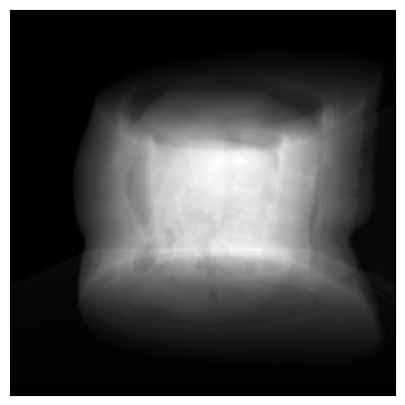

In [51]:
# Plot the DRR
plot_drr(img_liver, ticks=False)
plt.show()

In [9]:
# Make a mesh from the CT volume
ct = drr_to_mesh(drr, "surface_nets", threshold=1150, verbose=False)

# Make a mesh from the camera and detector plane
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx - 300, by, bz]], device=device)
pose = convert(rotations, translations, parameterization="euler_angles", convention="ZYX")
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
#plotter.export_html("render.html")

Widget(value='<iframe src="http://localhost:54115/index.html?ui=P_0x177e6a5bd90_0&reconnect=auto" class="pyvis…

In [35]:
from IPython.display import IFrame

IFrame("render.html", height=500, width=749)